In [1]:
cd ..

/Users/kimyoungh/GoogleDrive/rich/main/rich


In [2]:
import pickle
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

from trading.kis_data_loader import KISDataLoader

from datasets.trading_bc_transformer2_dataset import TradingBCTransformer2Dataset
from models.trading_bc_transformer2 import TradingBCTransformer2

In [3]:
with open('train_data/trading_bc_transformer/train_dataset_20_k200.pkl', 'rb') as f:
    dataset = pickle.load(f)

for key, data in dataset.items():
    print(key, data.shape)

dataset = TradingBCTransformer2Dataset(
    dataset['observations'], dataset['action_series'],
    dataset['updown_series'])

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

action_series (4194, 10, 20)
rets_series (4194, 10, 20)
rew_series (4194, 10, 20)
val_series (4194, 10, 20)
updown_series (4194, 20)
date_series (4194,)
observations (4194, 20, 8)


In [9]:
loader = KISDataLoader()

window = 250
eps = 1e-6

k200_org = loader.get_timeseries(
    '069500', start_date='20171228', end_date='20230421', period='D')
k200_org = k200_org.rename(columns={'turnover': 'value'})

In [32]:
np.argwhere(k200_org.index == '20191230')

array([[490]])

In [65]:
k200 = k200_org.iloc[490-250:]

kreturns = k200[['close']].pct_change()
kreturns = kreturns.iloc[window-1:]

k200 = k200[['open', 'high', 'low', 'close', 'value']]

ohlc = k200[
    ['open', 'high', 'low', 'close']].iloc[window-1:].copy()
o_values = ohlc.values
o_max = o_values.max(axis=1, keepdims=True)
o_min = o_values.min(axis=1, keepdims=True)

o_values = (o_values - o_min) / (o_max - o_min + eps)
ohlc = pd.DataFrame(o_values, columns=ohlc.columns,
                    index=ohlc.index)[['open', 'close']]

pmax = k200.rolling(window).max().dropna()
pmin = k200.rolling(window).min().dropna()
pnorm = (k200.iloc[window-1:] - pmin) / (pmax - pmin + eps)
direc = (kreturns > 0).astype(int)

pnorm = pd.concat((ohlc, pnorm, direc), axis=1)

obs_v = pnorm.values
obs = pnorm

factor_num = obs.shape[-1]
assets_in = torch.LongTensor([0]).view(-1)

In [66]:
model = TradingBCTransformer2()
model.eval()
model.load_state_dict(
    torch.load('trained/trading_bc_transformer2_k200/trading_bc_transformer2_k200_best.pt',
            map_location='cpu'))

<All keys matched successfully>

In [67]:
kreturns

,close
stck_bsop_date,
20191227,0.014628
20191230,-0.003514
20200102,-0.010578
20200103,-0.000184
20200106,-0.007643
...,...
20230417,0.000299
20230418,-0.001466
20230419,0.000749


In [68]:
print(k200.shape)
print(obs.shape)
print(kreturns.shape)

(1070, 5)
(821, 8)
(821, 1)


In [69]:
fee = 0.004
window = 250
tperiod = 20
action_seqs, return_seqs = [], []
actions_in = None
for t in range(len(obs)-1):
    if t < tperiod:
        obs_t = torch.FloatTensor(
            obs_v[:t+1].astype(float)).view(1, -1, factor_num)

        if t == 0:
            actions_in = None
        else:
            actions_in = action_preds
    else:
        obs_t = torch.FloatTensor(
            obs_v[t-tperiod+1:t+1].astype(float)).view(1, -1, factor_num)
        actions_in = action_preds[:, -(tperiod-1):]

    action_preds, outs, action_p = model.inference(assets_in, obs_t, actions_in)

    ret_t = kreturns.iloc[t+1, 0]
    if t > 0:
        tran = int(action_preds[0, -2] != action_preds[0, -1])
    else:
        tran = int(action_preds[0, -1] == 1)
    tfee = tran * fee

    if action_preds[0, -1] == 1:
        ret = ret_t - tfee
        #ret = (2 * ret_t) - tfee
        return_seqs.append(ret)
    else:
        ret = -ret_t - tfee
        #ret = (-2 * ret_t) - tfee
        #ret = 0. - tfee
        return_seqs.append(ret)

    action_seqs.append(action_preds[0, -1].item())
action_seqs = pd.DataFrame(action_seqs, index=kreturns.index[1:len(obs)],
                        columns=['bc_actions'])
return_seqs = pd.DataFrame(return_seqs, index=kreturns.index[1:len(obs)],
                        columns=['bc_returns'])
return_seqs['asset_returns'] = kreturns.iloc[1:len(obs)]

results = pd.concat((action_seqs, return_seqs), axis=1)

/Users/kimyoungh/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:544: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)
  return torch._transformer_encoder_layer_fwd(


In [70]:
action_preds

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [71]:
action_preds.shape

torch.Size([1, 20])

In [72]:
action_p

tensor([[0.6749, 0.3251]])

In [73]:
action_p.shape

torch.Size([1, 2])

In [74]:
outs.shape

torch.Size([1, 40, 64])

In [75]:
action_preds

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

<AxesSubplot:xlabel='stck_bsop_date'>

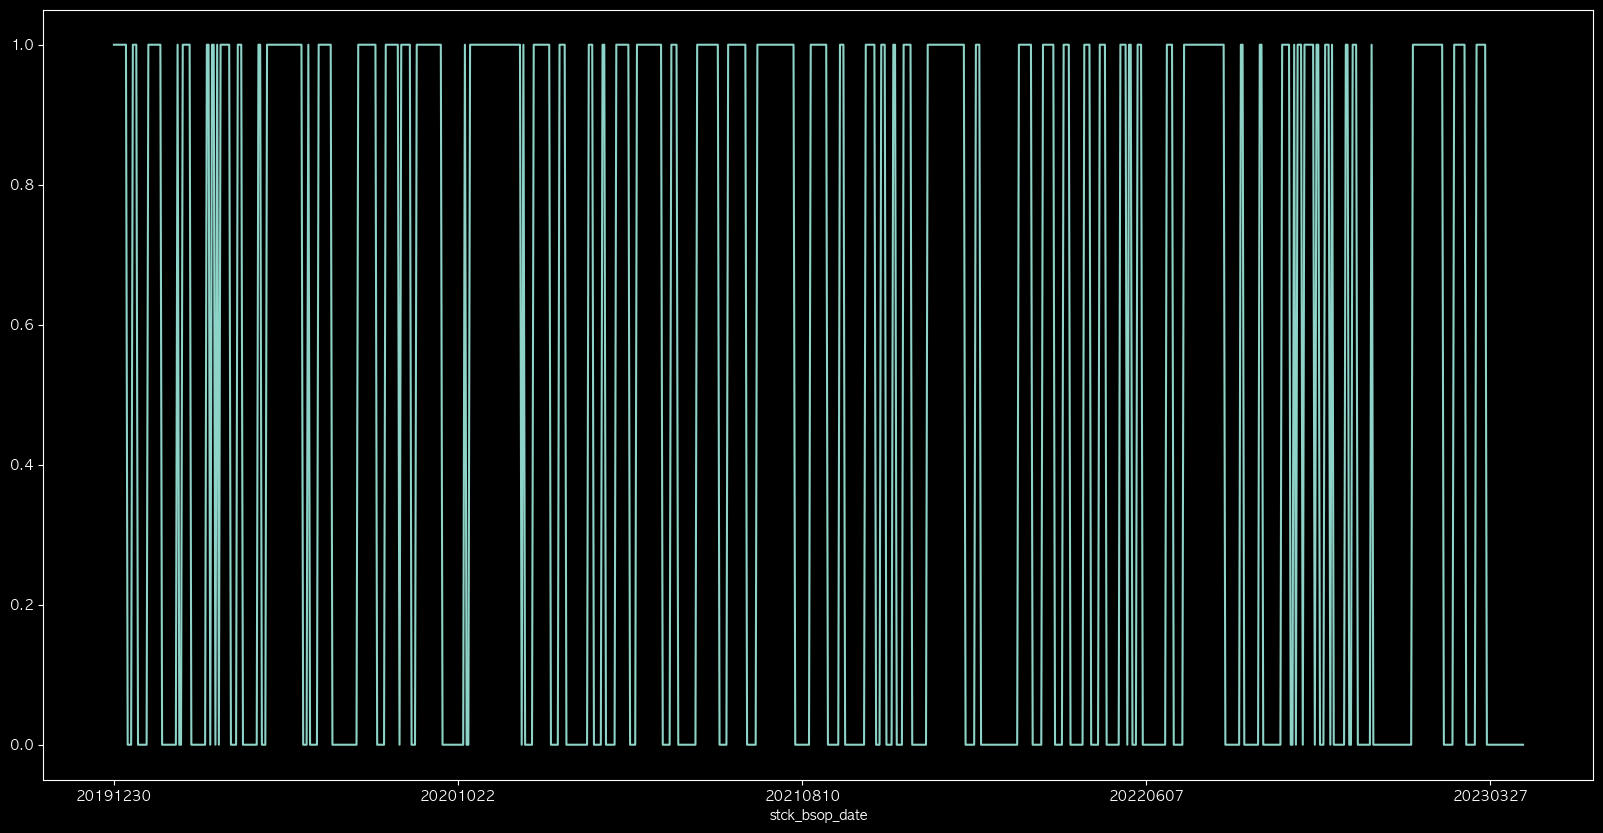

In [76]:
results['bc_actions'].plot(figsize=(20, 10))

<AxesSubplot:xlabel='stck_bsop_date'>

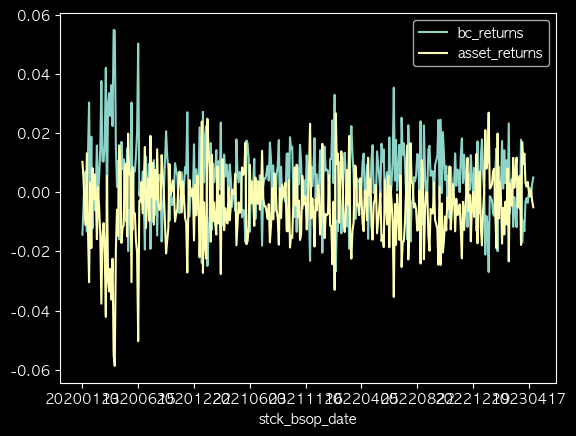

In [77]:
results[results['bc_actions'] == 0][['bc_returns', 'asset_returns']].plot()

In [78]:
results.tail(50)

,bc_actions,bc_returns,asset_returns
stck_bsop_date,,,
20230210,1,-0.002593,-0.002593
20230213,1,-0.005942,-0.005942
20230214,1,0.005978,0.005978
20230215,0,0.014910,-0.018910
20230216,0,-0.019905,0.019905
20230217,0,0.008846,-0.008846
20230220,0,-0.003401,0.003401
20230221,0,0.001400,-0.001400
20230222,0,0.017347,-0.017347


In [79]:
creturns = (1 + return_seqs).cumprod() - 1

<AxesSubplot:xlabel='stck_bsop_date'>

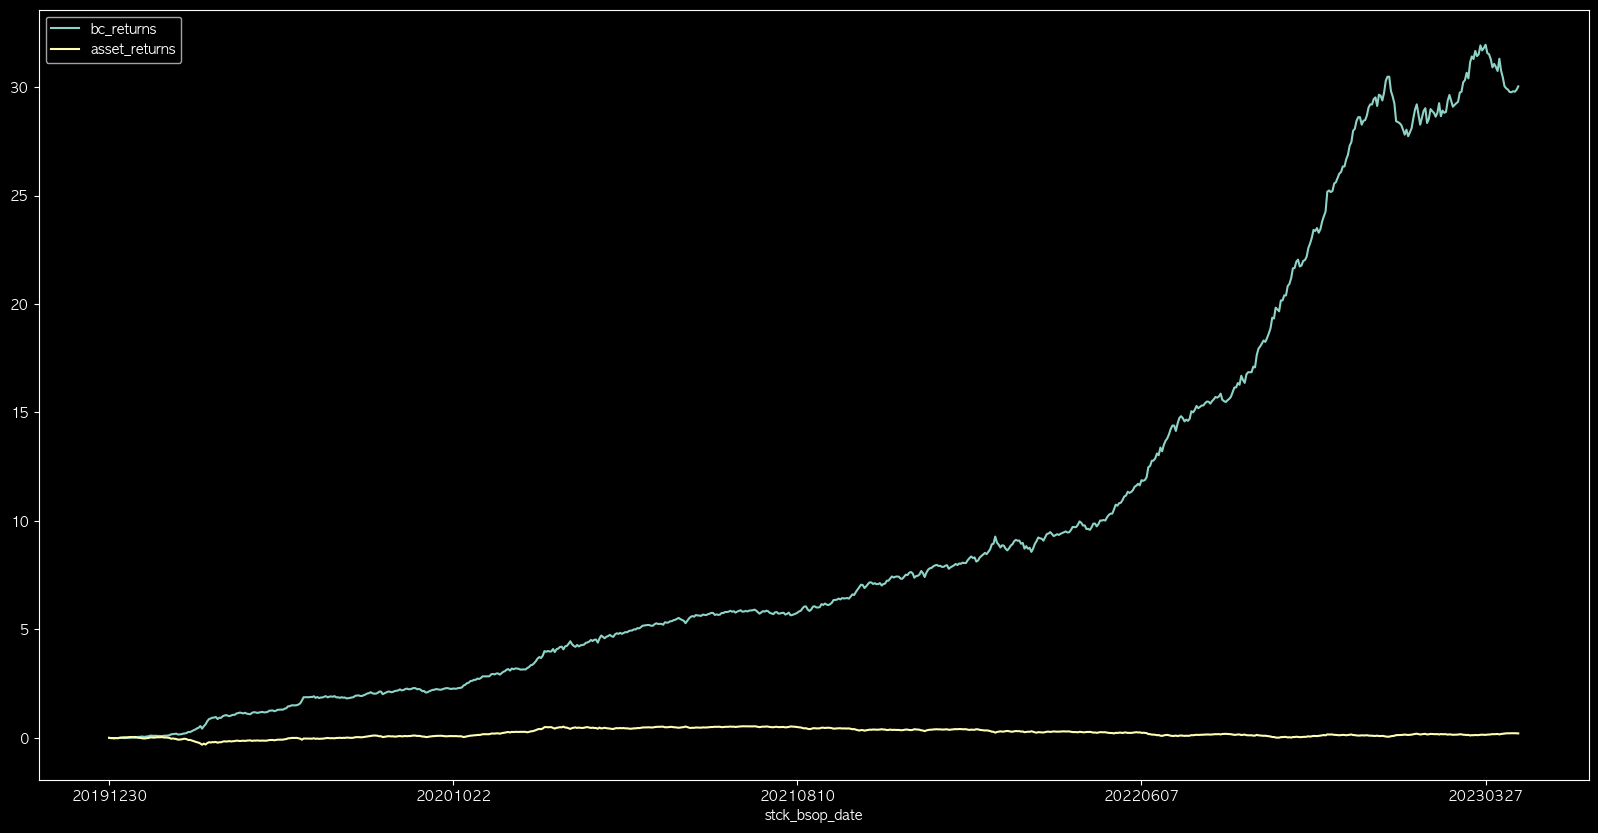

In [80]:
creturns.plot(figsize=(20, 10))

In [81]:
creturns

,bc_returns,asset_returns
stck_bsop_date,,
20191230,-0.007514,-0.003514
20200102,-0.018013,-0.014055
20200103,-0.018193,-0.014236
20200106,-0.025697,-0.021771
20200107,-0.015848,-0.011881
...,...,...
20230417,29.764674,0.210461
20230418,29.809786,0.208687
20230419,29.786702,0.209592
